# Adapter Trimming

In this notebook I look at the results from running atropos. There are no samples that are jumping out as being very problematic. There are some samples that have a lot of adapter contamination, that I may want to revisit. 

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-03-07 

CPython 3.5.2
IPython 5.3.0


In [2]:
from ncbi_remap.parser import parse_files, parse_atropos, parse_libsize

In [3]:
%%cache -s flist.pkl flist
# Get a list of all files
flist = []
for root, dirs, files in os.walk('../../output/prealignment/raw'):
    for file in files:
        flist.append(os.path.join(root, file))

In [4]:
%%cache -s atropos.pkl atropos
# Import logs and munge
atropos = parse_files(flist, '../../output/prealignment/raw/{experiment}/{sample}/{sample}_1.trim.clean.fastq.gz.log', parse_atropos)
atropos.columns = [x.strip() for x in atropos.columns]

In [35]:
# Split into PE and SE
pe = atropos[~atropos['pct_read2_adapters'].isnull()].copy()
pe.dropna(axis=1, how='all', inplace=True)   # drop columns that are completely missing (i.e. SE)
pe.fillna(0, inplace=True)       # fill in any odd missing value
pe.sort_values('pct_read1_adapters', inplace=True)
pe['pct_polyA_read1'] = pe['Number First read: Adapter polyA trimmed'] / pe['Total read pairs processed'] * 100
pe['pct_polyA_read2'] = pe['Number Second read: Adapter polyA trimmed'] / pe['Total read pairs processed'] * 100
pe['pct_polyT_read1'] = pe['Number First read: Adapter polyT trimmed'] / pe['Total read pairs processed'] * 100
pe['pct_polyT_read2'] = pe['Number Second read: Adapter polyT trimmed'] / pe['Total read pairs processed'] * 100
pe['pct_illumina_read1'] = pe['Number First read: Adapter illumina trimmed'] / pe['Total read pairs processed'] * 100
pe['pct_illumina_read2'] = pe['Number Second read: Adapter illumina trimmed'] / pe['Total read pairs processed'] * 100

se = atropos[atropos['pct_read2_adapters'].isnull()].copy()
se.dropna(axis=1, how='all', inplace=True)
se.fillna(0, inplace=True)
se.sort_values('pct_read1_adapters', inplace=True)
se['pct_polyA'] = se['Number Adapter polyA trimmed'] / se['Total reads processed'] * 100
se['pct_polyT'] = se['Number Adapter polyT trimmed'] / se['Total reads processed'] * 100
se['pct_illumina'] = se['Number Adapter illumina trimmed'] / se['Total reads processed'] * 100

## Single End

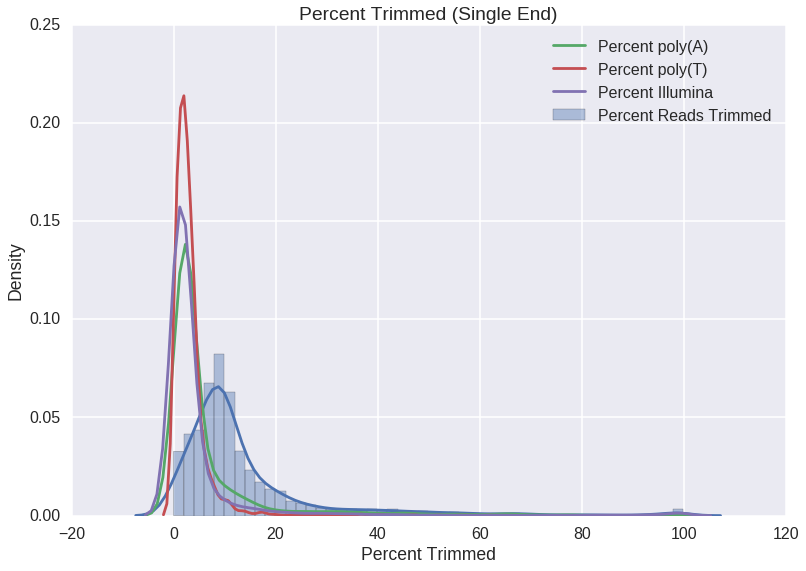

In [57]:
# Distribution of percent trimmed (se)
sns.distplot(se['pct_read1_adapters'], label='Percent Reads Trimmed')
sns.distplot(se['pct_polyA'], hist=False, label='Percent poly(A)')
sns.distplot(se['pct_polyT'], hist=False, label='Percent poly(T)')
ax = sns.distplot(se['pct_illumina'], hist=False, label='Percent Illumina')
ax.set_title('Percent Trimmed (Single End)')
_ = ax.set_xlabel('Percent Trimmed')
_ = ax.set_ylabel('Density')

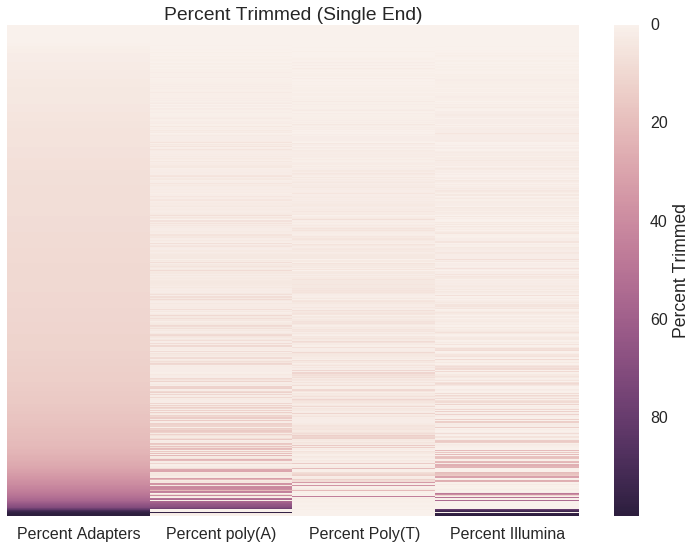

In [9]:
# heatmap percent trimmed (se)
ax = sns.heatmap(se[['pct_read1_adapters', 'pct_polyA', 'pct_polyT', 'pct_illumina']], 
            yticklabels=False,
            cbar_kws={'label': 'Percent Trimmed'}
           )
cbar = ax.collections[0].colorbar
cbar.ax.invert_yaxis()
_ = ax.xaxis.set_ticklabels(['Percent Adapters', 'Percent poly(A)', 'Percent Poly(T)', 'Percent Illumina'])
_ = ax.set_title('Percent Trimmed (Single End)')

## Paired End

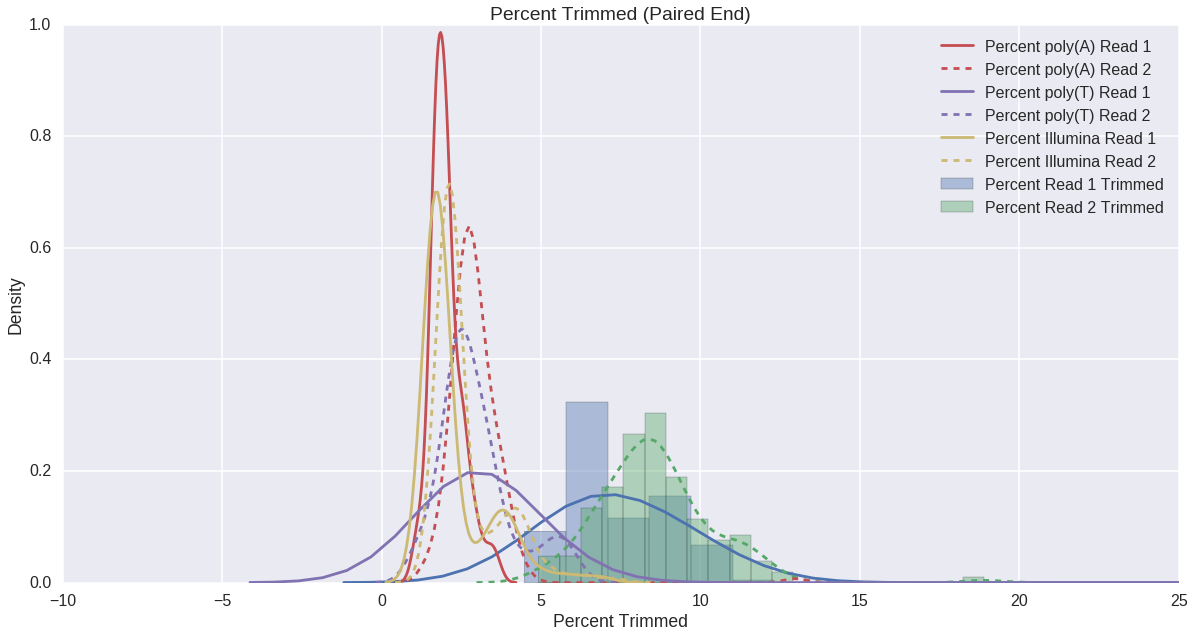

In [56]:
# Distribution of percent trimmed (pe)
fig = plt.figure(figsize=(20, 10))
sns.distplot(pe['pct_read1_adapters'], label='Percent Read 1 Trimmed')
sns.distplot(pe['pct_read2_adapters'], label='Percent Read 2 Trimmed', kde_kws={'ls': '--'})
sns.distplot(pe['pct_polyA_read1'], hist=False, label='Percent poly(A) Read 1', color=sns.color_palette()[2])
sns.distplot(pe['pct_polyA_read2'], hist=False, label='Percent poly(A) Read 2', color=sns.color_palette()[2], kde_kws={'ls': '--'})
sns.distplot(pe['pct_polyT_read1'], hist=False, label='Percent poly(T) Read 1', color=sns.color_palette()[3])
sns.distplot(pe['pct_polyT_read2'], hist=False, label='Percent poly(T) Read 2', color=sns.color_palette()[3], kde_kws={'ls': '--'})
sns.distplot(pe['pct_illumina_read1'], hist=False, label='Percent Illumina Read 1', color=sns.color_palette()[4])
ax = sns.distplot(pe['pct_illumina_read2'], hist=False, label='Percent Illumina Read 2', color=sns.color_palette()[4], kde_kws={'ls': '--'})
_ = ax.set_title('Percent Trimmed (Paired End)')
_ = ax.set_xlim(-10, 25)
_ = ax.set_xlabel('Percent Trimmed')
_ = ax.set_ylabel('Density')

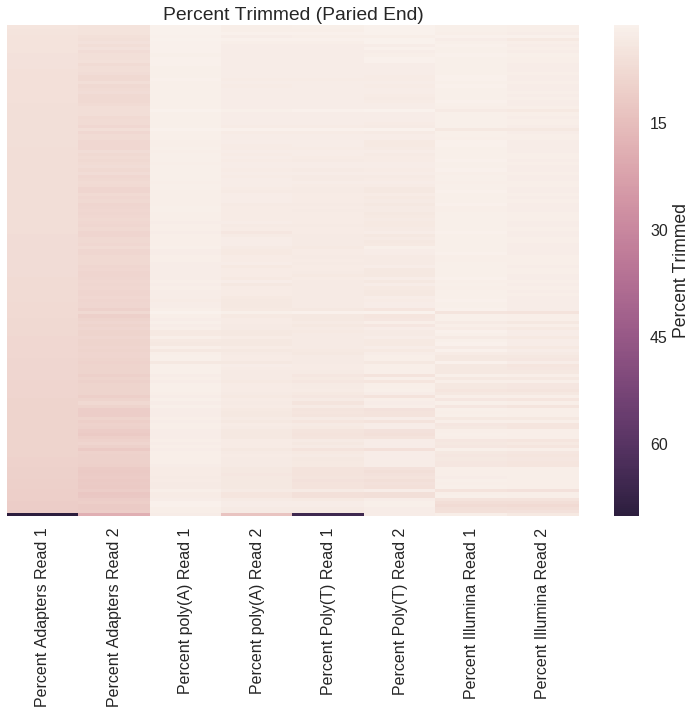

In [60]:
# heatmap percent trimmed (pe)
ax = sns.heatmap(pe[[
    'pct_read1_adapters',  'pct_read2_adapters', 
    'pct_polyA_read1',  'pct_polyA_read2', 
    'pct_polyT_read1',  'pct_polyT_read2', 
    'pct_illumina_read1', 'pct_illumina_read2']], 
            yticklabels=False,
            cbar_kws={'label': 'Percent Trimmed'}
           )
cbar = ax.collections[0].colorbar
cbar.ax.invert_yaxis()
_ = ax.xaxis.set_ticklabels([
    'Percent Adapters Read 1', 'Percent Adapters Read 2', 
    'Percent poly(A) Read 1', 'Percent poly(A) Read 2', 
    'Percent Poly(T) Read 1', 'Percent Poly(T) Read 2', 
    'Percent Illumina Read 1', 'Percent Illumina Read 2'])
_ = ax.set_title('Percent Trimmed (Paried End)')